### Описание  
А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана.

### Описание колонок
`experimentVariant` – вариант эксперимента  
`version` – версия приложения  
`purchase` – факт покупки  

### Задача
1. Запустите A/A-тест.
2. Посчитать FPR на уровне альфа = 0.05.
3. Найти причины поломки сплит-системы, ориентируясь на результаты эксперимента.
4. Написать выводы, которые можно сделать на основе анализа результатов A/A-теста.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
# считаем данные
df = (
    pd.read_csv('https://stepik.org/media/attachments/lesson/396012/hw_aa.csv',
                 sep=';')
            .drop('Unnamed: 0', axis=1)
     )

In [3]:
df.head()

,uid,experimentVariant,version,purchase
0,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [4]:
# пропуски
df.isna().sum()

uid                  0
experimentVariant    0
version              0
purchase             0
dtype: int64

In [5]:
df.version.value_counts()

v2.8.0      82835
v2.9.0      23954
v3.8.0.0    11804
v3.7.4.0     8425
Name: version, dtype: int64

In [6]:
df.experimentVariant.value_counts()

1    63916
0    63102
Name: experimentVariant, dtype: int64

In [7]:
# разделим данные
var_0 = df.query('experimentVariant == 0')
var_1 = df.query('experimentVariant == 1')

Проведём A/A тест для имеющихся данных.

In [8]:
# обернём А/А тест в функцию
def aa_test(ser_1, ser_2, simulations = 1000, n_s = 1000):
    res = []

    # запуск симуляций A/A теста
    for i in tqdm(range(simulations)):
        s1 = ser_1.sample(n_s, replace = False).values
        s2 = ser_2.sample(n_s, replace = False).values
        res.append(stats.mannwhitneyu(s1, s2)[1])       # сохраняем pvalue

    plt.hist(res, bins = 50)
    plt.style.use('ggplot')
    plt.xlabel('pvalues')
    plt.ylabel('frequency')
    plt.title("Histogram of mannwhitneyu A/A simulations ")
    plt.show()

    # Проверяем, что количество ложноположительных случаев не превышает альфа
    return sum(np.array(res) <0.05) / simulations

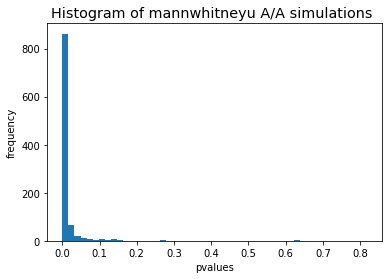

0.947

In [9]:
aa_test(var_0.purchase, var_1.purchase)

Как видно, с данными что-то не так: А/А тест показывает, что в 95% случаев симуляций выборки различаются.

Сгруппируем датафрэйм по варианту и версии приложений и сравним конверсии.

In [11]:
# конверсия по варианту и версии приложения
mean_by_version_variant = df.groupby(['experimentVariant', 'version'], as_index=False).agg({'purchase': 'mean'})

In [12]:
mean_by_version_variant

,experimentVariant,version,purchase
0,0,v2.8.0,0.000993
1,0,v2.9.0,0.074658
2,0,v3.7.4.0,0.059943
3,0,v3.8.0.0,0.057604
4,1,v2.8.0,0.045606
5,1,v2.9.0,0.071304
6,1,v3.7.4.0,0.063018
7,1,v3.8.0.0,0.062848


Воспользуемся функцией pivot и стилями, чтобы сделать информацию более удобной для восприятия.

In [13]:
# сводная таблица конверсий по версиям и группам
(
    mean_by_version_variant
        .pivot(index='version', 
               columns='experimentVariant', 
               values='purchase')
        .style
        .background_gradient(cmap='viridis', axis=1, vmin=0.01)
        .format("{:.2%}")
)

experimentVariant,0,1
version,,
v2.8.0,0.10%,4.56%
v2.9.0,7.47%,7.13%
v3.7.4.0,5.99%,6.30%
v3.8.0.0,5.76%,6.28%


Уберём версию v2.8.0 из датафрэймов и снова проведём А/А тест.

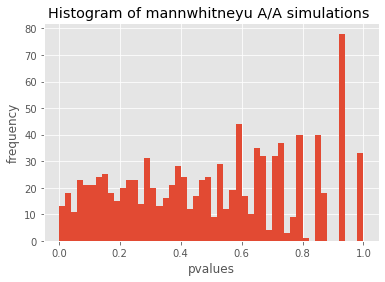

0.036

In [14]:
# А/А тест для данных без версии v2.8.0
(
    aa_test(var_0.query('version != "v2.8.0"').purchase, 
            var_1.query('version != "v2.8.0"').purchase)
)

Как видно, ситуация значительно улучшилась. Различия возникают уже в менее чем 0.05 случаях.

Взглянем на количество строк в данных по версии приложения.

In [15]:
var_0.version.value_counts()

v2.8.0      41283
v2.9.0      11921
v3.8.0.0     5694
v3.7.4.0     4204
Name: version, dtype: int64

In [16]:
var_1.version.value_counts()

v2.8.0      41552
v2.9.0      12033
v3.8.0.0     6110
v3.7.4.0     4221
Name: version, dtype: int64

In [17]:
# найдём разницу в количестве строк с разными версиями приложения, в процентах
(
var_1.version.value_counts()
    .sub(var_0.version.value_counts())
    .div(var_0.version.value_counts())
    .to_frame()
    .rename(columns={'version': 'difference'})
    .style
    .background_gradient(cmap='viridis')
    .format("{:.2%}")
)

,difference
v2.8.0,0.65%
v2.9.0,0.94%
v3.8.0.0,7.31%
v3.7.4.0,0.40%


Как видно, количество строк с версией v3.8.0.0 отличается на 7.31% (в var_1 больше).
Проведём ещё одно А/А тестирование, теперь и без v3.8.0.0.

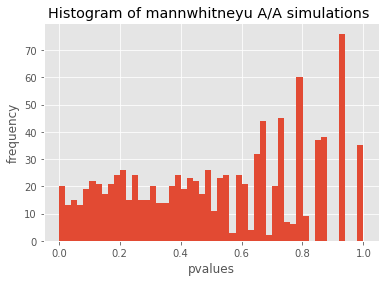

0.04

In [18]:
# А/А тест для данных без версий v2.8.0 и v3.8.0.0
(
    aa_test(var_0.query('(version != "v2.8.0") and (version != "v3.8.0.0")').purchase, 
            var_1.query('(version != "v2.8.0") and (version != "v3.8.0.0")').purchase)
)

Разницу уже сложно заметить.
Итак, причина неправильной работы сплит системы: неверное деление на группы пользователей приложения версии v2.8.0. Конверсия в группе "0" была 0,1%, в то время как конверсия в группе "1" для этой же версии приложения была уже 4,56%.